# Fraud Detection Classifier

    Edgar Hernandez
    email: edgar.hdz@hotmail.com


The data set was obtained from `kaggle` and can be downloaded [here](https://www.kaggle.com/ntnu-testimon/paysim1/kernels). It is a syntetically generated data set `"[using] aggregated data from [a] private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods"` [$^{1}$](https://www.kaggle.com/ntnu-testimon/paysim1/home). It consists of 6 million data rows, containing financial information of transactions and current account status. 

In this __notebook__ it is presented how the data was firstly delved with, how it was processed and prepared in order to build a binary classification model, which eventually indicate whether a transaction was fraudulent or not.

The classification model was built using tensorflow's estimator API.
____________
Data overview: (as taken by dataset description)

**`step`** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**`type`** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**`amount`** - amount of the transaction in local currency.

**`nameOrig`** - customer who started the transaction

**`oldbalanceOrg`** - initial balance before the transaction

**`newbalanceOrig`** - new balance after the transaction

**`nameDest`** - customer who is the recipient of the transaction

**`oldbalanceDest`** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**`newbalanceDest`** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**`isFraud`** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**`isFlaggedFraud`** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


_________

# Table of contents
 * [Importing packages and dataset](#section1)
 <a href='#section1'></a>
 * [Data exploration](#exploration)
 <a href='#exploration'></a>
 * [Data processing](#processing)
 <a href='#processing'></a>
  * [Data filtering](#filtering)
 <a href='#filtering'></a>
  * [log fitting](#log)
 <a href='#log'></a>
  * [Data separation](#separation)
 <a href='#separation'></a>
 * [Building the model](#model)
 <a href='#model'></a>
  * [Data preparation](#preparation)
 <a href='#preparation'></a>
  * [Numerical data normalization](#normal)
 <a href='#normal'></a>
  * [Cross-validation](#crossval)
 <a href='#crossval'></a>
  * [Training the model](#train)
 <a href='#train'></a>
   * [Creating cross-val sets](#4fold)
 <a href='#4fold'></a>
 * [Results](#results)
 <a href='#results'></a>
  * [Importing results](#import)
 <a href='#import'></a>
  * [Accuracy vs. no. of epochs](#acc)
 <a href='#acc'></a>
  * [Confusion matrix](#conf)
 <a href='#conf'></a>

__________

<a class="anchor" id="section1"></a>

# Importing packages and dataset 

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import colors

In [102]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

# Data exploration 
<a class="anchor" id="exploration"></a>

In [6]:
display(df.sample(10).head())
print('rows: {}, columns: {}'.format(np.shape(df)[0],np.shape(df)[1]))

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5416393,378,PAYMENT,2188.73,C1385479455,54326.0,52137.27,M640449074,0.00,0.00,0,0
6275516,637,TRANSFER,399177.43,C493842442,68.0,0.00,C639604508,0.00,399177.43,0,0
4234819,306,CASH_OUT,110649.45,C767847092,40390.0,0.00,C2110852875,0.00,110649.45,0,0
4256131,306,CASH_IN,137425.78,C1254761202,12864.0,150289.78,C1512756933,1182867.63,1045441.85,0,0
3262561,251,CASH_OUT,220153.29,C2049140962,777015.0,556861.71,C1995026239,0.00,220153.29,0,0


rows: 6362620, columns: 11


`isFraud == 0` and `isFraud == 1` stand for data labeled as not fraud and fraud, respectively 

In [80]:
val,lab = zip(*Counter(df[df.isFraud==1].step).items())

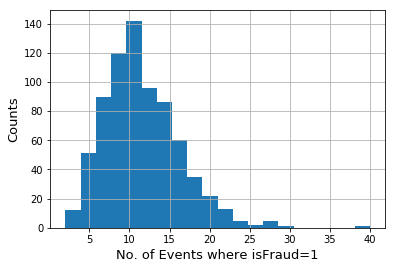

On average, 11 fraud events per hour


In [81]:
plt.hist(lab,bins=20)
plt.gca().grid(True)
plt.gca().set_xlabel(r'No. of Events where isFraud=1',fontsize=13)
plt.gca().set_ylabel(r'Counts',fontsize=13)

plt.show()

print('On average, %i fraud events per hour' %np.average(lab))

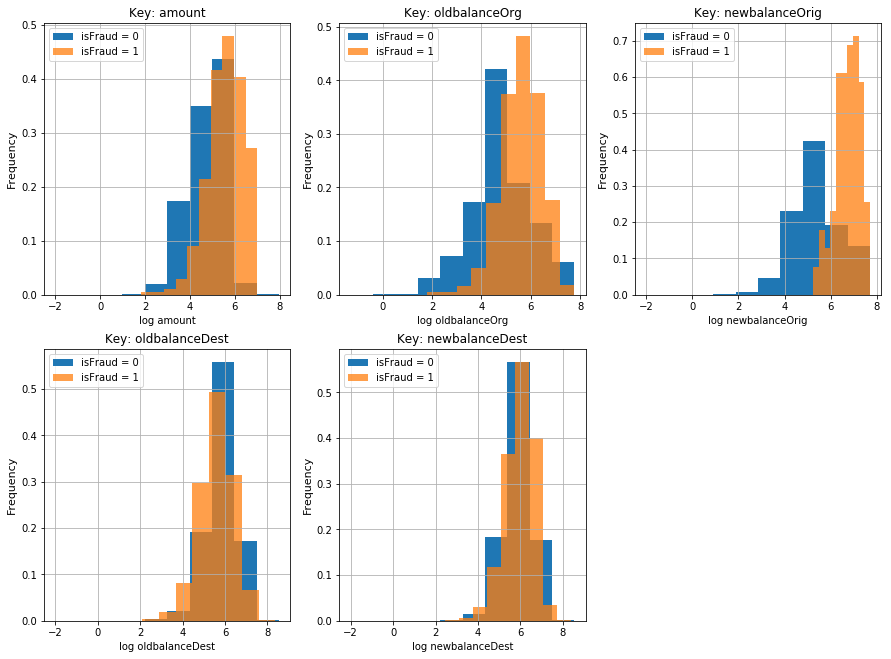

In [7]:
fig, ax = plt.subplots(2,3,figsize=(15,11))
i,k = 0,0
for key in df.keys():
    if df[key].dtype == float:     
        ax[i,k].hist([np.log10(things) for things in df[key] if things!=0],density = True,label='isFraud = 0')
        ax[i,k].set_title(r'Key: {}'.format(key),fontsize = 12)
        ax[i,k].hist([np.log10(things) for things in df[df.isFraud==1][key] if things!=0],
                     density = True,alpha=.75,label = 'isFraud = 1')
        ax[i,k].set_ylabel('Frequency',fontsize = 11)
        ax[i,k].set_xlabel('log {}'.format(key))
        ax[i,k].legend()
        ax[i,k].grid(True)
        k+=1
    if k%3== 0 and k!=0:
        i=+1
        k=0
fig.delaxes(ax[(1,2)])    

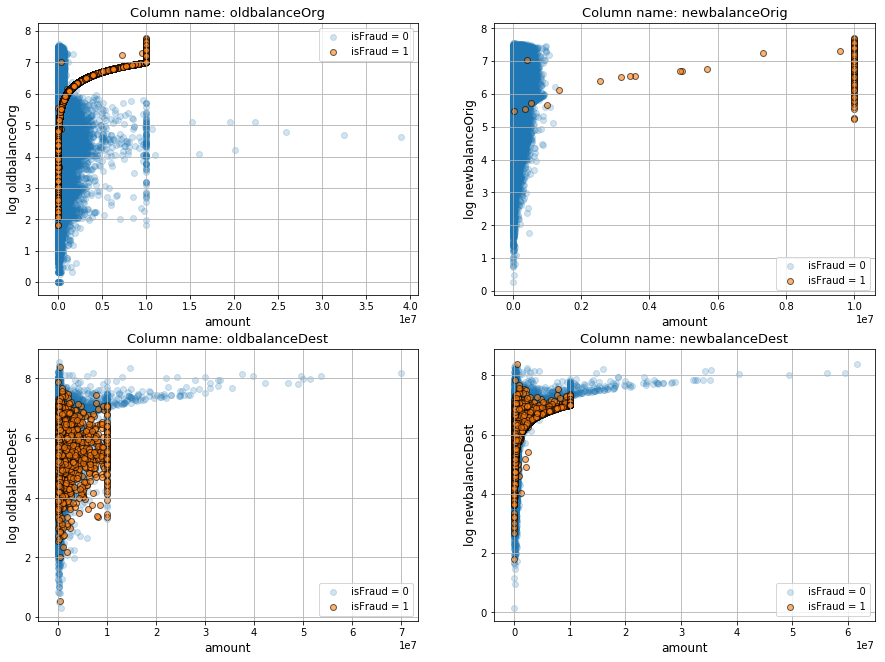

In [8]:
fig, ax = plt.subplots(2,2,figsize=(15,11))
i,k = 0,0

for key in df.keys():
    if df[key].dtype == float and key!='amount':   

        sub_df = df[df.isFraud==1]
        sub_df = sub_df[(sub_df[key]!=0)&(sub_df.amount!=0)]
        y = np.log10(sub_df[key])
        x = sub_df.amount


        sample_df = df[(df[key]!=0)&(df.amount!=0)].sample(frac=.05)
        y1,x1  = np.log10(sample_df[key]), sample_df.amount

        ax[i,k].scatter(x1,y1,alpha=0.2,label ='isFraud = 0')
        ax[i,k].scatter(x,y,alpha=0.6,edgecolors ='black',label = 'isFraud = 1')
        ax[i,k].set_title(r'Column name: {}'.format(key),fontsize = 13)
        ax[i,k].grid(True)
        ax[i,k].legend()
        ax[i,k].set_ylabel(r'log {}'.format(key),fontsize=12), ax[i,k].set_xlabel(r'amount',fontsize=12)
        
        k+=1
    if k%2== 0 and k!=0:
        i=+1
        k=0

In the above graphs, we can see that in the graph `[0,0] -upper left-` and `[0,1] there is a clear __$log_{10}$__ relationship between `oldbalanceOrg` vs `amount` where `isFraud == 1`. We may probably use this to our advantage when defining which type of model we will be using, as well as what the `validation` and `training` sets will be. 


Meaning that most likely we will not be using the entire data set to train the model


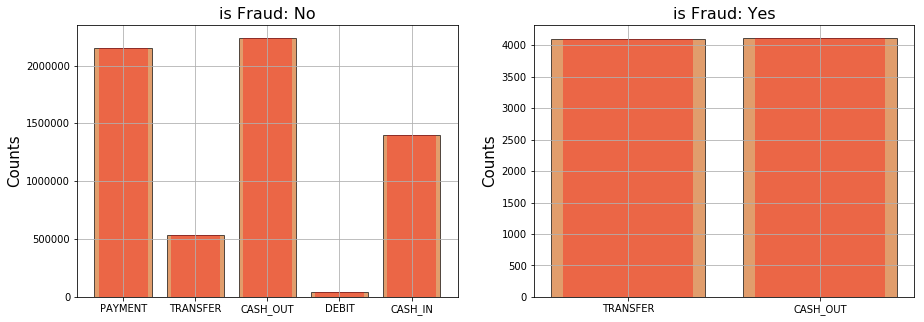

In [9]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
i=0
for x,tag in zip([df['type'], df[df['isFraud']==1].type],['No','Yes']):
    lab, val = zip(*Counter(x).items())
    ax[i].bar(lab,val,color='chocolate',edgecolor='black',alpha=0.65)
    ax[i].bar(lab,val,width =0.68,color='red',alpha=0.35)
    ax[i].set_ylabel(r'Counts',fontsize= 15)
    ax[i].set_title('is Fraud: {}'.format(tag),fontsize=16)
    ax[i].grid(True)
    i+=1


From the plots above, it can already be seen that in in the `type` column, only two transactions categories are present when dealing with `isFraud == 1`. These are `TRANSFER` and `CASH_OUT`.

This means we can narrow down the data that we will use to train the binary classifier as just having those two categories for the `type` column.

Applying a filter including only `TRANSFER` and `CASH_OUT` we obtain similar plots as the ones displayed before, where again `isFraud == 0` and `isFraud == 1` stand for data labeled as fraud and not fraud, respectively.

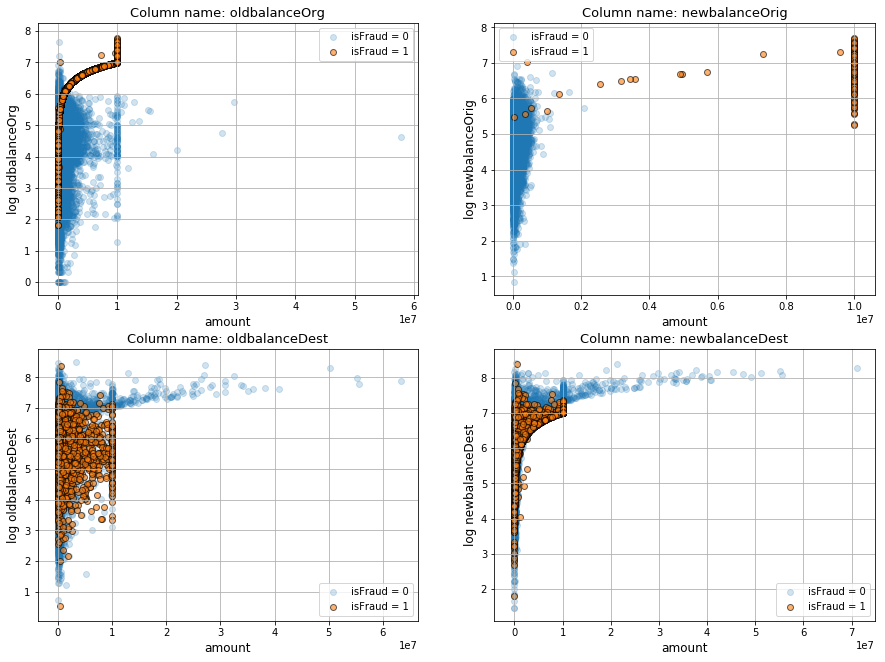

In [10]:
fig, ax = plt.subplots(2,2,figsize=(15,11))
i,k = 0,0

for key in df.keys():
    if df[key].dtype == float and key!='amount':   

        sub_df = df[(df.isFraud==1) & (df.type.isin(['TRANSFER','CASH_OUT']))]
        sub_df = sub_df[(sub_df[key]!=0)&(sub_df.amount!=0)]
        y = np.log10(sub_df[key])
        x = sub_df.amount


        sample_df = df[(df[key]!=0)&(df.amount!=0)&(df.type.isin(['TRANSFER','CASH_OUT']))].sample(frac=.05)
        y1,x1  = np.log10(sample_df[key]), sample_df.amount

        ax[i,k].scatter(x1,y1,alpha=0.2,label ='isFraud = 0')
        ax[i,k].scatter(x,y,alpha=0.6,edgecolors ='black',label = 'isFraud = 1')
        ax[i,k].set_title(r'Column name: {}'.format(key),fontsize = 13)
        ax[i,k].grid(True)
        ax[i,k].legend()
        ax[i,k].set_ylabel(r'log {}'.format(key),fontsize=12), ax[i,k].set_xlabel(r'amount',fontsize=12)
        
        k+=1
    if k%2== 0 and k!=0:
        i=+1
        k=0

___________

<a class="anchor" id="processing"></a>

# Data processing 

<a class="anchor" id="filtering"></a>

## Data filtering  

Starting the filtration of the data with data labeled as `isFraud == 1`

In [83]:
sub_df = df[(df.isFraud==1) & (df.type.isin(['TRANSFER','CASH_OUT']))]

In [84]:
print("Filtered data length (isFraud == 1): {} -Containing only 'TRANSFER' and 'CASH_OUT'".format(len(sub_df)))

Filtered data length (isFraud == 1): 8213 -Containing only 'TRANSFER' and 'CASH_OUT'


In [88]:
sub_df = sub_df[(sub_df['oldbalanceOrg']!=0)&(sub_df.amount!=0)]
print("Filtered data length (isFraud == 1): {} -Containing values different than zero for the 'oldbalanceOrg' and\n'amount' columns".format(len(sub_df)))
print("Filtered data length (isFraud == 1): {}  -Containing values different than zero for the 'newbalanceOrg' and\n'amount' columns".format(len(sub_df[(sub_df['newbalanceOrig']!=0)&(sub_df.amount!=0)])))

Filtered data length (isFraud == 1): 8172 -Containing values different than zero for the 'oldbalanceOrg' and
'amount' columns
Filtered data length (isFraud == 1): 160  -Containing values different than zero for the 'newbalanceOrg' and
'amount' columns


Graph `[0,1] -upper left-` is not truly representative of the data we would want to use, inasmuch as it only contains $\large\frac{160_{\hspace{.2cm}items}}{8213_{\hspace{.1cm}items}}$, where `isFraud = 1` (those displayed as orange circles), whereas graph `[0,0] -upper-right-` includes $\large\frac{8172_{\hspace{.15cm}items}}{8213_{\hspace{.15cm}items}}$ items $\approx$ 100 %

 <a class="anchor" id="log"></a>

## Log fitting
As commented in the [`Data exploration`](#exploration) section, and using the $log_{10}$ relationship that `oldbalanceOrg` has vs `amount` where `isFraud == 1`, a logarithmic fitting is proposed.

Where the function where we will be fitting the $log_{10}$ of `oldbalanceOrg` vs `amount` is:

- $\large log_{10}(y)$ = $\large m \cdot log_{10}(x)$ + $\large log_{10}(b)$
        or
- $\large y$ = $\large x^m$ $\cdot$ $\large 10^b$


This will come in handy later on, since we can then use the data around the `log fit` as the data to build our binary classification model

In [14]:
sub_df = df[(df.isFraud==1) & (df.type.isin(['TRANSFER','CASH_OUT']))]
sub_df = sub_df[(sub_df['oldbalanceOrg']!=0)&(sub_df.amount!=0)]
y = np.log10(sub_df['oldbalanceOrg'])
x = np.log10(sub_df.amount)

In [15]:
m, b = np.polyfit(x,y,1) 
print('slope: %.3f and intercept: %.3f of the log fitting' % (m,b))

slope: 1.010 and intercept: -0.052 of the log fitting


In [16]:
sample_df = df[(df['oldbalanceOrg']!=0)&(df.amount!=0)&(df.type.isin(['TRANSFER','CASH_OUT']))].sample(frac=.05)
y1,x1  = np.log10(sample_df['oldbalanceOrg']), np.log10(sample_df.amount)

In [17]:
y_fit_log = np.log10(np.arange(10,10**7.5,100))*m+b
y_fit_plus = np.log10(np.arange(10,10**7.5,100))*m+(b +1)
y_fit_neg = np.log10(np.arange(10,10**7.5,100))*m+(b-1)

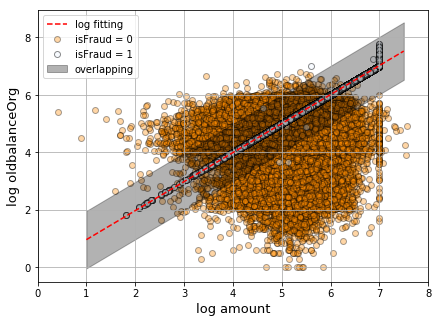

In [18]:
sub_df = df[(df.isFraud==1) & (df.type.isin(['TRANSFER','CASH_OUT']))]
sub_df = sub_df[(sub_df['oldbalanceOrg']!=0)&(sub_df.amount!=0)]
y = np.log10(sub_df['oldbalanceOrg'])
x = np.log10(sub_df.amount)
plt.figure(figsize=(7,5))
plt.plot(np.log10(np.arange(10,10**7.5,100)),y_fit_log,'r--',label = 'log fitting')
#plt.plot(np.log10(np.arange(0.001,10**7,100)),y_fit_plus,'r--')
#plt.plot(np.log10(np.arange(0.001,10**7,100)),y_fit_neg,'r--')
plt.scatter(x1,y1,alpha=0.35,edgecolors='black',c='darkorange',label = 'isFraud = 0')
plt.scatter(x,y,alpha = 0.45,edgecolors='black',c ='aliceblue',label ='isFraud = 1')

plt.fill_between(np.log10(np.arange(10,10**7.5,100)),y_fit_plus,y_fit_neg,alpha=0.30,color='black',label ='overlapping')
plt.gca().set_xlim(0,8)
plt.gca().set_xlabel(r'log amount',fontsize=13)
plt.gca().set_ylabel(r'log oldbalanceOrg',fontsize=13)
plt.legend()
plt.gca().grid(True)

Displaying just a sample fraccion (`5%`) of `amount` vs `oldbalanceOrg` for the case in which `isFraud == 0`. The shaded line indicates when an overlapp between `isFraud == 1` and `isFraud == 0` is happening. Meaning that we can only keep the data which lies inside the shaded area. And thus, use it in order to build our model.

Use the newly fitted function to assign the data that will be used to train the model $\ddot\smile$


In [19]:
len(df[df.isFraud==1])

8213

Data where `amount == 0` and `isFraud == 1`, faulty data? Probably marked as `isFraud` by the software before being able to record the transaction

In [20]:
print(len(df[df.amount == 0]))
display(df[df.amount == 0]) ## They are all fraud

16


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


<a class="anchor" id="separation"></a>

## Data separation

Creating both an `upper_bound` and a `lower_bound` using the fitted function. This will be used in order to separate the data that will be used for the model.

In [91]:
df['upper_bound'] = [(np.log10(x)*m + (b + 1)) if x!=0 else 0 for x in df.amount]
df['lower_bound'] = [(np.log10(x)*m + (b - 1)) if x!=0 else 0 for x in df.amount]

In [92]:
sub_df = df[df.oldbalanceOrg>0]

In [93]:
len(sub_df),len(df)

(4260171, 6362620)

In [94]:
sub_df = sub_df[((np.log10(sub_df.oldbalanceOrg)<sub_df.upper_bound))&((np.log10(sub_df.oldbalanceOrg)>sub_df.lower_bound))]

In [95]:
len(sub_df),len(df)

(2168953, 6362620)

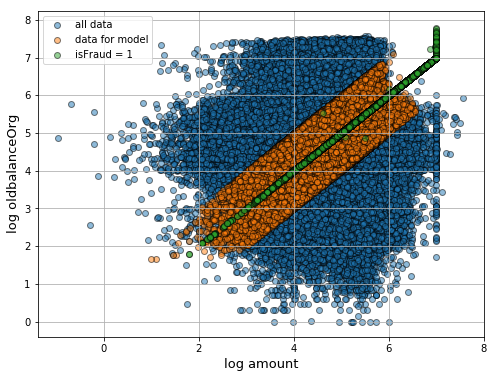

Percentage of Fraud labeled items wrt all data: 0.38%
isFraud labeled data  (0.38%):                  8169 items
Rest of the data (99.62%):                   2168953 items


In [99]:
temp = sub_df.sample(frac=0.05)
temp2 = df[(df.amount>0) & (df.oldbalanceOrg>0)].sample(frac=0.05)
x, y = np.log10(temp.amount),np.log10(temp.oldbalanceOrg)
x1,y1 = np.log10(sub_df[sub_df.isFraud==1].amount),np.log10(sub_df[sub_df.isFraud==1].oldbalanceOrg)
x2,y2 = np.log10(temp2.amount),np.log10(temp2.oldbalanceOrg)

plt.figure(figsize = (8,6))
plt.scatter(x2,y2,alpha =0.5,edgecolors='black',label = 'all data')
plt.scatter(x,y,alpha = 0.5,edgecolors='black',label='data for model')
plt.scatter(x1,y1,alpha=0.5,edgecolors='black',label = 'isFraud = 1')
plt.gca().grid(True)
plt.gca().set_xlabel(r'log amount',fontsize=13)
plt.gca().set_ylabel(r'log oldbalanceOrg',fontsize=13)
plt.legend()
plt.show()
pr = (len(sub_df[sub_df.isFraud ==1])/len(sub_df)*100)
print('Percentage of Fraud labeled items wrt all data: %.2f%%' % pr)
print('isFraud labeled data  (%.2f%%):                  %s items' % (pr,len(sub_df[sub_df.isFraud ==1])))
print('Rest of the data (%.2f%%):                   %s items' % ((100-pr),len(sub_df)))

Since only 0.38 % of `sub_df` is marked as fraud (`isFraud == 1`), and in order to maintain data homogeneity wrt to labeled and unlabeled data, the training data will consist of 0.76 % of the whole `sub_df`. 

This means that we will be taking randomly 0.38% from data labeled as `isFraud == 0`, in order to build the data set which will be used to train our classification model.

_______
<a class="anchor" id="model"></a>


# Building the model

<a class="anchor" id="preparation"></a>
## Data preparation

Previously we commented that there was a data separation, which was based on whether it followed the `log fitting` or not [[`Data exploration`](#exploration)]. Since the remaining data would still be considerably larger compared to the `isFraud == 1` labeled data, a random sampling of the `isFraud == 0` was proposed.

This consisted on taking a fraction (0.38%) of the `isFraud == 0` labeled data, and concatenating it to the `isFraud == 1` labeled data. With it, obtaining a data set which we can use to train and validate our model.


In [26]:
frame = []
frame.append(sub_df[sub_df.isFraud==0].sample(frac = pr/100))
frame.append(sub_df[sub_df.isFraud==1]) 

In [27]:
new_sub_df = pd.concat(frame).sample(frac=1).reset_index()

It is important to `reset_index()`, since the way cross validation will find the indices is by using `pd.DataFrame.iloc` instead of `pd.DataFrame.loc`. This is shown further below in section `?`

In [28]:
Counter(new_sub_df.isFraud).items()

dict_items([(1, 8169), (0, 8138)])

In [33]:
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold as SKF

<a class="anchor" id="normal"></a>
## Numerical data normalization

In [29]:
cols = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'] ## 

In [30]:
new_sub_df[cols] = new_sub_df[cols].apply(lambda x: (x-x.min())/(x.max()-x.min()))

Displaying only the first 10 rows of the normalized numerical input

In [31]:
new_sub_df.head(10)

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,upper_bound,lower_bound
0,6281786,650,CASH_OUT,0.005046,C1711085884,0.000847,0.000000,C1148781766,0.000000,0.000213,1,0,5.698876,3.698876
1,3660984,275,CASH_OUT,0.019790,C937706436,0.006866,0.004260,C426663838,0.002245,0.003077,0,0,6.297959,4.297959
2,4757582,333,TRANSFER,0.186188,C1160054760,0.031247,0.000000,C223760078,0.000000,0.000000,1,0,7.281158,5.281158
3,1030739,89,TRANSFER,0.076657,C112075481,0.012865,0.000000,C1906745138,0.000000,0.000000,1,0,6.891891,4.891891
4,4348553,309,CASH_IN,0.001518,C1710419657,0.000506,0.000916,C652155216,0.003729,0.003657,0,0,5.173266,3.173266
5,4385369,312,PAYMENT,0.000793,C1697451700,0.000093,0.000000,M1020227186,0.000000,0.000000,0,0,4.889976,2.889976
6,1059673,116,CASH_OUT,0.269481,C1699838041,0.045226,0.000000,C1076792770,0.002428,0.013807,1,0,7.443352,5.443352
7,1070045,122,CASH_OUT,0.099462,C291762198,0.016692,0.000000,C91538557,0.000000,0.004202,1,0,7.006128,5.006128
8,5720327,398,TRANSFER,0.149824,C664914101,0.025144,0.000000,C228214204,0.000000,0.000000,1,0,7.185840,5.185840
9,3497531,259,CASH_OUT,0.017209,C2087397178,0.010810,0.009519,C1357965227,0.017755,0.018445,0,0,6.236671,4.236671


In [34]:
numerical_cols = {}
for i in cols:
    numerical_cols[i] = tf.feature_column.numeric_column(i)

In [35]:
feat_cols = [numerical_cols[things] for things in numerical_cols]

<a class="anchor" id="crossval"></a>
## Cross-validation

In order to validate the model, it was decided to use a `4fold Cross-validation` framework. Meaning that `4` different and independent models will be trained and validated using each of the cross-validation data sets.

The way in which the data was split, was by following a `stratified` splitting, which returns stratified folds of training and validation data. An example of the stratified folds is shown in the image below.  

In [36]:
x_data = new_sub_df.drop('isFraud',axis=1)
y_val = new_sub_df['isFraud']

In [37]:
X = x_data
y = y_val
kf = SKF(n_splits=4, shuffle=True)
kf.get_n_splits(X,y)
kfold_train=[]
kfold_test=[]
#print(kf)  

for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    kfold_train.append([train_index])
    kfold_test.append([test_index])

In [38]:
strat_all=[]
for j in range(0,4):
    strat_list = []
    for i in range(0,len(x_data)):
        if i in list(kfold_train[:][j][0]):
            strat_list.append(100)
        else:
            strat_list.append(1)
    strat_all.append(strat_list)
    
strat_all = np.array(strat_all)

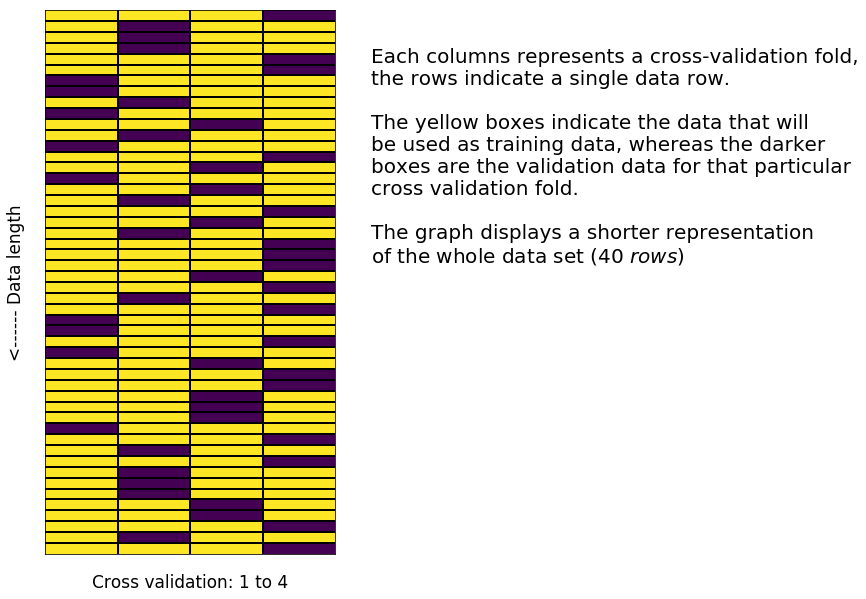

In [39]:
fig, ax = plt.subplots(figsize=(15,10))

ax.imshow(strat_all[:,0:50].T,aspect=0.15)

#
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 3, 1));
ax.set_yticks(np.arange(0.5, 49, 1));

ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
ax.set_ylabel(r'<------ Data length', fontsize = 17,labelpad=20)
ax.set_xlabel(r'Cross validation: 1 to 4',fontsize = 17, labelpad=20)
ax.text(4, 13, 'Each columns represents a cross-validation fold,\nthe rows indicate a single data row.\n\nThe yellow boxes indicate the data that will\nbe used as training data, whereas the darker\nboxes are the validation data for that particular\ncross validation fold.\n\nThe graph displays a shorter representation\nof the whole data set ($40$ $rows$)', size=20, ha='left',va='center')
plt.show()

<a class="anchor" id="train"></a>
## Training the model 

All cross-validation folds were trained in parallel and ran through the terminal using the script named `code_1.py` which depends on the defined function contained in the script `train_model.py` (click [here](https://github.com/edghyhdz/fraud_detection_classifier/blob/master/code_1.py) and [here](https://github.com/edghyhdz/fraud_detection_classifier/blob/master/train_model.py), respectively). The training was done using tensorflow's estimator API. The hyperparameters were not thoroughly tested, but given the accuracy of the trained model it is thought to be ok. 

<a class="anchor" id="4fold"></a>
### Creating 4 fold cross-validation data sets 

In [40]:
for i in range(4):
    train_fold = new_sub_df.iloc[list(kfold_train[:][i][0])]
    test_fold = new_sub_df.iloc[list(kfold_test[:][i][0])]
    train_fold.to_csv('train_fold_{}.csv'.format(i+1))
    test_fold.to_csv('test_fold_{}.csv'.format(i+1))

Example of one of the cross-val folds (test data)

In [41]:
pd.read_csv('test_fold_1.csv',index_col=0).reset_index().drop(columns = 'level_0').head(10)

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,upper_bound,lower_bound
0,1059673,116,CASH_OUT,0.269481,C1699838041,0.045226,0.000000,C1076792770,0.002428,0.013807,1,0,7.443352,5.443352
1,1070045,122,CASH_OUT,0.099462,C291762198,0.016692,0.000000,C91538557,0.000000,0.004202,1,0,7.006128,5.006128
2,3497531,259,CASH_OUT,0.017209,C2087397178,0.010810,0.009519,C1357965227,0.017755,0.018445,0,0,6.236671,4.236671
3,5580976,393,TRANSFER,0.043290,C1282477979,0.007265,0.000000,C1783092125,0.000000,0.000000,1,0,6.641245,4.641245
4,3040665,234,TRANSFER,0.021063,C836135331,0.003535,0.000000,C2142575639,0.000000,0.000000,1,0,6.325289,4.325289
5,1118629,130,PAYMENT,0.010353,C2063031859,0.000371,0.000000,M1503623549,0.000000,0.000000,0,0,6.013871,4.013871
6,6277179,640,CASH_OUT,0.004981,C981772775,0.000836,0.000000,C49776683,0.002120,0.002326,1,0,5.693177,3.693177
7,6065304,512,TRANSFER,0.068421,C1873188115,0.011483,0.000000,C315115812,0.000000,0.000000,1,0,6.842031,4.842031
8,6283809,658,CASH_OUT,0.873059,C1590395791,0.146522,0.000000,C1505080875,0.001086,0.037964,1,0,7.959014,5.959014
9,4100257,301,PAYMENT,0.004179,C611925716,0.002052,0.001623,M174619860,0.000000,0.000000,0,0,5.616327,3.616327


___________

<a class="anchor" id="results"></a>
# Results

<a class="anchor" id="import"></a>
## Importing results

In [42]:
test_score_,train_score_ = [],[]

for i in range(1,5):
    train_score_.append(pd.read_csv('scores_{}.csv'.format(i),index_col=0)['train_score'].values)
    test_score_.append(pd.read_csv('scores_{}.csv'.format(i),index_col=0)['hold_score'].values)

train_df = pd.DataFrame(np.reshape(train_score_,(4,5)))
hold_df =pd.DataFrame(np.reshape(test_score_,(4,5)))

In [43]:
train_av, train_sd = [],[]
hold_av, hold_sd = [],[]
for i in range(0,5):

    train_av.append(np.average(train_df[i]))
    train_sd.append(np.std(train_df[i]))
    
    hold_av.append(np.average(hold_df[i]))
    hold_sd.append(np.std(hold_df[i]))

<a class="anchor" id="acc"></a>
## Accuracy vs No. of epochs

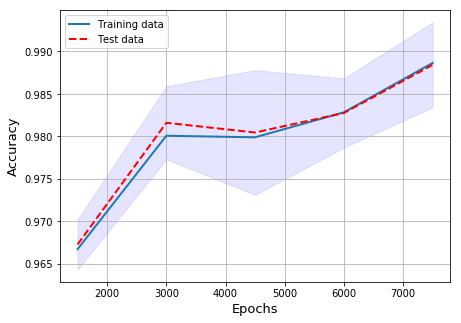

In [44]:
up_ = [x[0]+x[1] for x in zip(hold_av,hold_sd)]
low_ = [x[0]-x[1] for x in zip(hold_av,hold_sd)]

plt.figure(figsize =(7,5))
plt.plot(np.arange(1500,9000,1500),train_av,linewidth =2,label ='Training data')
plt.fill_between(np.arange(1500,9000,1500),up_,low_,alpha=0.10,color='blue')
plt.plot(np.arange(1500,9000,1500),hold_av,'r--', linewidth =2,label ='Test data')
plt.gca().set_ylabel(r'Accuracy',fontsize=13)
plt.gca().set_xlabel(r'Epochs',fontsize=13)
plt.gca().grid()
plt.legend(loc = 'upper left')

plt.show()

The shaded area is the average and ± standard deviations of the `test_data` for all 4 cross-validation folds

In [54]:
'Accuracy: %.f%%' %(hold_av[4]*100)

'Accuracy: 99%'

<a class="anchor" id="conf"></a>
## Confusion matrix

In [55]:
from sklearn.metrics import confusion_matrix
import itertools

<a class="anchor" id="trainmodel"></a>
### Importing one of the trained models

We import one of the trained models to see the predictions it did on the validation set. 

In [56]:
dnn_model = tf.estimator.DNNClassifier(hidden_units=[16,16,16,16],feature_columns=feat_cols,model_dir='/home/edgar/Desktop/Fraud/saved_models_1/',n_classes=2,optimizer=lambda: tf.train.AdamOptimizer(
    learning_rate=tf.train.exponential_decay(
        learning_rate=0.001,
        global_step=tf.train.get_global_step(),
        decay_steps=5000,
        decay_rate=0.86)))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/edgar/Desktop/Fraud/saved_models_1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff55fea7400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [57]:
X_hold = pd.read_csv('test_fold_1.csv',index_col=0)

In [58]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_hold[cols],
      y=X_hold['isFraud'],
      batch_size=50,
      num_epochs=1,
      shuffle=False)
dnn_model.evaluate(eval_input_func)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-20-16:46:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/edgar/Desktop/Fraud/saved_models_1/model.ckpt-30589
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Finished evaluation at 2019-02-20-16:46:29
INFO:tensorflow:Saving dict for global step 30589: accuracy = 0.99435997, accuracy_baseline = 0.50098085, auc = 0.99801135, auc_precision_recall = 0.9975513, average_loss = 0.042303193, global_step = 30589, label/mean = 0.50098085, loss = 2.10381, precision = 0.9888674, prediction/mean = 0.4913371, recall = 1.0
INFO:tensorflow:Saving 'che

{'accuracy': 0.99435997,
 'accuracy_baseline': 0.50098085,
 'auc': 0.99801135,
 'auc_precision_recall': 0.9975513,
 'average_loss': 0.042303193,
 'label/mean': 0.50098085,
 'loss': 2.10381,
 'precision': 0.9888674,
 'prediction/mean': 0.4913371,
 'recall': 1.0,
 'global_step': 30589}

In [59]:
predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=X_hold[cols], 
    num_epochs = 1, 
    shuffle = False)

In [60]:
predictions = list(dnn_model.predict(input_fn=predict_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/edgar/Desktop/Fraud/saved_models_1/model.ckpt-30589
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [61]:
print("No. of predictions: {}".format(len(predictions)))

y_pred=[]
for p in predictions:
    y_pred.append(int(p['classes'][0]))

No. of predictions: 4078


In [62]:
predicts = pd.DataFrame(np.array([list(X_hold['isFraud']),y_pred])).T
predicts.columns=('y_test','y_pred')

In [63]:
prob=[]
for p in predictions:
    cat0,cat1 = p['probabilities']*100
    prob.append([cat0,cat1])
probs=pd.DataFrame(prob,dtype=int)

In [64]:
prediction_matrix =pd.concat([predicts,probs],axis=1)

In [65]:
class_names = ['NOT FRAUD','IS FRAUD']

Confusion matrix, without normalization
[[2012   23]
 [   0 2043]]


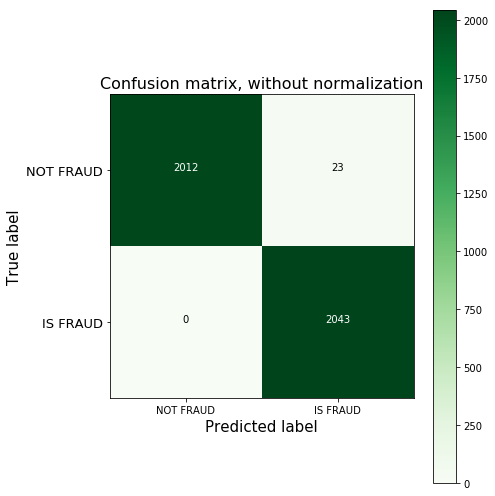

Normalized confusion matrix
[[0.99 0.01]
 [0.   1.  ]]


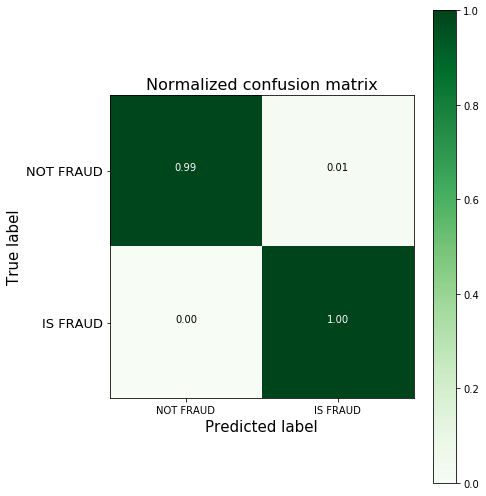

In [66]:
y_test = prediction_matrix.y_test.values
y_pred = prediction_matrix.y_pred.values
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0,fontsize=10)
    plt.yticks(tick_marks, classes,fontsize=13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=10)

    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.tight_layout()
    #plt.savefig('confusion_matrix.jpeg', dpi=500)
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


Out of `4078` predictions, `4055` were correctly predicted, `23` were false positives, and `0` false negatives






